In [ ]:
%matplotlib inline
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
#Test
sns.set(font_scale = 1.5)

In [ ]:
# Connect to Neo4j
driver = GraphDatabase.driver('neo4j://212.235.239.171:22333', auth=('neo4j', 'ngslbd2020'))

def read_query(query):
    with driver.session(database="semmed43cord19") as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [ ]:
# Infer similarity network between drugs based on TREATS relationship
read_query("""
CALL apoc.periodic.iterate(
"MATCH (p1:phsu)-[r1:TREATS]->(:dsyn)<-[r2:TREATS]-(p2:phsu)
WHERE id(p1) > id(p2) AND r1.freq > 1 AND r2.freq > 1
RETURN p1,p2",
"MERGE (p1)-[t:SIMILAR_NEW]-(p2) ON CREATE SET t.weight = 1 ON MATCH SET t.weight = t.weight + 1",
{batchSize:10000})
""")

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-3-380d45ff30a2>, line 8)

In [ ]:
# Potential drug repurposing

read_query("""
MATCH (c:Concept{name:"Headache"})<-[t:TREATS]-(existing)
WITH c,existing, t.freq as frequency
ORDER BY frequency DESC LIMIT 5
MATCH (existing)-[r:SIMILAR_NEW]-(potential)
WHERE NOT (potential)-[:TREATS]->(c)
WITH potential, sum(r.weight) as total_weight
ORDER BY total_weight
DESC LIMIT 10
RETURN potential.name as potential
""")

,potential
0,ascorbic acid
1,curcumin
2,glucose
3,Insulin
4,Anti-Anxiety Agents
5,vitamin E
6,Hydroxymethylglutaryl-CoA Reductase Inhibitors
7,Immunoglobulins
8,resveratrol
9,Inflammation Mediators


In [ ]:
read_query("""
MATCH (u:phsu)
RETURN count(*) as total_nodes,
       sum(CASE WHEN (u)-[:SIMILAR_NEW]-() THEN 1 END) as nodes_with_similar_relationships
""")

,total_nodes,nodes_with_similar_relationships
0,27395,7548


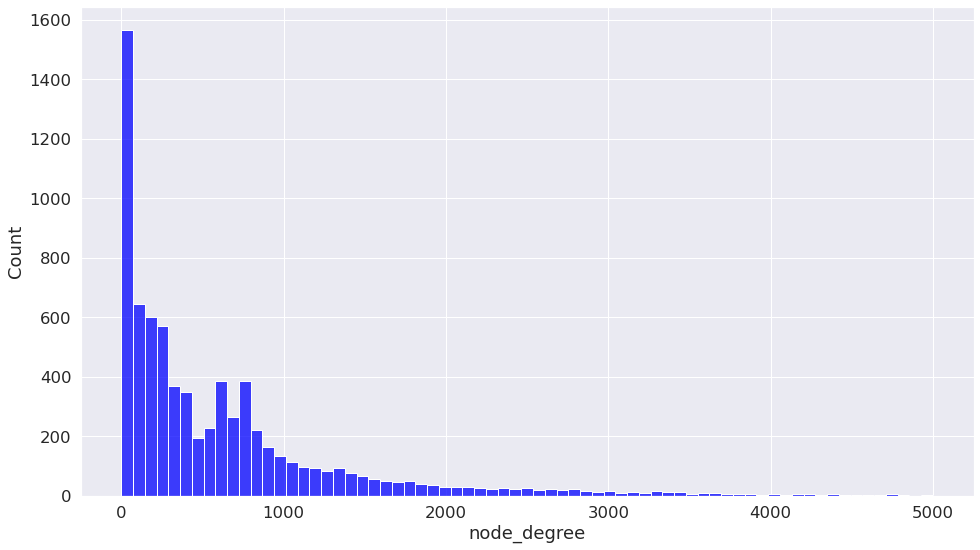

In [ ]:
# Node degree distribution

data = read_query("""
MATCH (u:phsu)
WHERE (u)-[:SIMILAR_NEW]-()
RETURN size((u)-[:SIMILAR_NEW]-()) as node_degree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_degree",data=data, color="blue", binrange=[0,5000])

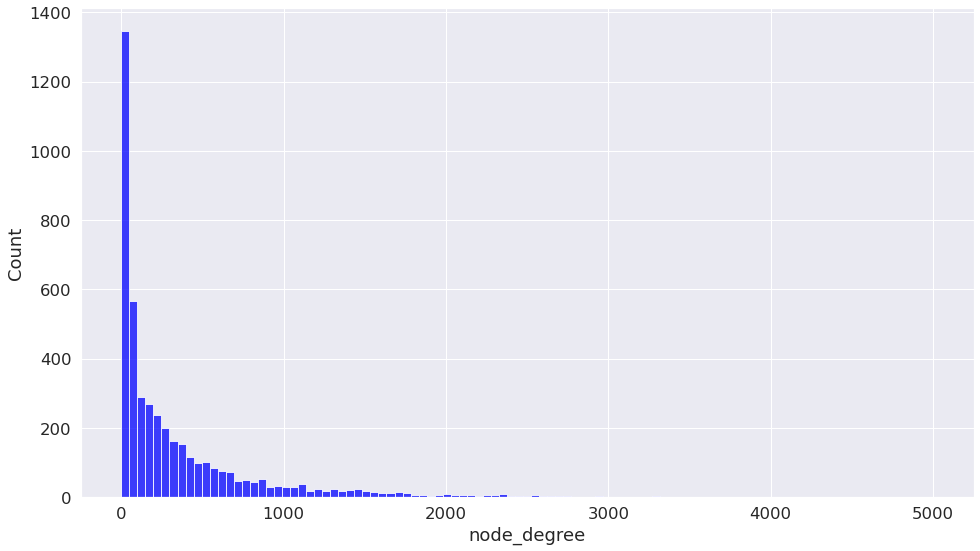

In [ ]:
# Node degree if we look at relationships with weight greater than 1
data = read_query("""
MATCH (u:phsu)-[s:SIMILAR_NEW]-()
WHERE s.weight > 1 
RETURN u, count(*) as node_degree
""")

fig, ax = pyplot.subplots(figsize=(16,9))
ax = sns.histplot(x="node_degree",data=data, color="blue", binrange=[0,5000])

# Communities with only using relationship weight greater than 1


In [ ]:
# Project the graph
read_query("""
CALL gds.graph.create.cypher("drug",
"MATCH (u:phsu) WHERE (u)-[:SIMILAR_NEW]-() RETURN id(u) as id",
"MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)
 WHERE r.weight > 1
 RETURN id(s) as source, id(t) as target, r.weight as weight")
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:phsu) WHERE (u)-[:SIMILAR_NEW]-() RET...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,drug,7548,1518372,48962


In [ ]:
# WCC
read_query("""
CALL gds.wcc.stats("drug")
""")['componentDistribution'].to_list()

[{'p99': 1,
  'min': 1,
  'max': 4437,
  'mean': 2.4262295081967213,
  'p90': 1,
  'p50': 1,
  'p999': 1,
  'p95': 1,
  'p75': 1}]

In [ ]:
# Louvain write
read_query("""
CALL gds.louvain.write("drug", {relationshipWeightProperty:"weight", 
  writeProperty:"drug-louvain", includeIntermediateCommunities:true})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,2157,7548,0.166262,"[0.15368850703311226, 0.16626243675615782]",2,3117,"{'p99': 1, 'min': 1, 'max': 2001, 'mean': 2.42...",10,0,6523,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [ ]:
# First level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,first_level_community,communitySize
0,6470,1545
1,24,977
2,3391,310
3,1096,299
4,1246,258
5,6154,252
6,7292,185
7,1432,168
8,1055,122
9,2416,98


In [ ]:
# investigate first level communities members

read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize, collect(u.name) as members
ORDER BY communitySize DESC SKIP 2 LIMIT 10
""")['members'][2]

['Procaine',
 'Etodolac',
 'etofenamate',
 'lesinurad',
 'Vitamin K 1',
 'tripterine',
 'glucosamine',
 'raloxifene',
 'polylactic acid-polyglycolic acid copolymer',
 'dinoprostone',
 'alendronate',
 'menatetrenone',
 'benziodarone',
 "3,4-O-isopropylidene-3,3',4,5'-tetrahydroxystilbene",
 'epimedii',
 'methylcellulose',
 'escin',
 'Etidronate',
 'sodium ferulate',
 'human calcitonin',
 'methylprednisolone acetate',
 'tafamidis',
 'cholecalciferol',
 'Ibandronate',
 'Tolmetin',
 'Fluorides',
 'grape seed extract',
 'Emodin',
 'sinapinic acid',
 'Glucosamine Sulfate',
 'tryptophan',
 'Ginsenoside',
 'tocotrienols',
 'risedronate sodium',
 'Endopeptidases',
 'fentiazac',
 'Hydrogel',
 'Calcium + vitamin D',
 'diclofenac sodium',
 'shikonin',
 'rosmarinic acid',
 'Adrenergic alpha-Antagonists',
 'lithium chloride',
 'Diphosphonates',
 'Nitric Oxide Synthase Inhibitor',
 'Cyclooxygenase Inhibitors',
 'dipyrone',
 'piroxicam',
 'Arthrotec',
 'HYLAN G-F 20',
 'Milurite',
 'parthenolide',
 'r

In [ ]:
# Second level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug-louvain`)
RETURN u.`drug-louvain`[1] as second_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,second_level_community,communitySize
0,1432,2001
1,24,977
2,3391,593
3,1096,484
4,1055,353
5,2883,24
6,6470,5
7,3513,2
8,8,1
9,7,1


In [ ]:
read_query("""
CALL gds.graph.drop("drug")
""")

,graphName,database,memoryUsage,sizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,drug,semmed43cord19,2804 KiB,2872272,None,None,MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weig...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,180,32220,1.0,2021-05-31T08:48:21.443772000+00:00,2021-05-31T08:48:28.336108000+00:00,{'relationships': {'__ALL__': {'weight': 'Floa...


# Communities with only using relationship weight greater than 1
# And ignoring nodes with degree higher than 1500

In [ ]:
read_query("""
MATCH (u:phsu)-[s:SIMILAR_NEW]-()
WHERE s.weight > 1 
WITH u, count(*) as node_degree
WHERE node_degree > 1500
RETURN u.name as drug
""")['drug'].to_list()

['melatonin',
 'Docosahexaenoic Acids',
 'heparin',
 'Heparin, Low-Molecular-Weight',
 'Erythropoietin',
 'N,N-dimethylarginine',
 'acetylcholine',
 'acetylcysteine',
 'Lactate',
 'carnitine',
 'Active ingredient',
 'human leukocyte interferon',
 'rosuvastatin',
 'cyclosporine',
 'dinoprostone',
 'pioglitazone',
 'Insulin',
 'Vaccines',
 'Amino Acids',
 'cholecalciferol',
 'adrenomedullin',
 'glucose',
 'tryptophan',
 'valproic acid',
 'Endopeptidases',
 'coenzyme Q10',
 'Growth Hormone',
 'colchicine',
 'furosemide',
 'methylprednisolone',
 'cyclophosphamide',
 'Adrenergic alpha-Antagonists',
 'Adrenergic beta-Antagonists',
 'Angiotensin-Converting Enzyme Inhibitors',
 'sildenafil',
 'Antidiabetics',
 'infliximab',
 'resveratrol',
 'cortisone',
 'Angiopoietin-2',
 'angiotensin II',
 'estradiol',
 'atorvastatin',
 'vitamin A',
 'tretinoin',
 'Serotonin Uptake Inhibitors',
 'estrogens',
 'clopidogrel',
 'Biological Products',
 'Biological Response Modifiers',
 'etanercept',
 'Inflammati

In [ ]:
# Project the graph
read_query("""
CALL gds.graph.create.cypher("drug",
"MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weight > 1
 WITH u, count(*) as node_degree
 WHERE node_degree < 1500 
 RETURN id(u) as id",
"MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)
 WHERE r.weight > 1
 RETURN id(s) as source, id(t) as target, r.weight as weight",
 {validateRelationships:false})
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:phsu)-[s:SIMILAR_NEW]-() WHERE s.weig...,MATCH (s:phsu)-[r:SIMILAR_NEW]-(t)\n WHERE r.w...,drug,4259,827806,7414


In [ ]:
# WCC
read_query("""
CALL gds.wcc.stats("drug")
""")['componentDistribution'].to_list()

[{'p99': 2,
  'min': 1,
  'max': 4135,
  'mean': 34.90983606557377,
  'p90': 1,
  'p50': 1,
  'p999': 4135,
  'p95': 1,
  'p75': 1}]

In [ ]:
# Louvain write
read_query("""
CALL gds.louvain.write("drug", {relationshipWeightProperty:"weight", 
  writeProperty:"drug_louvain_filtered", includeIntermediateCommunities:true})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,60,4259,0.289003,"[0.27217153414271134, 0.2890032958689275]",2,128,"{'p99': 752, 'min': 1, 'max': 1570, 'mean': 33...",3,0,2365,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [ ]:
# First level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,first_level_community,communitySize
0,6470,1480
1,24,911
2,3391,302
3,1096,285
4,6154,247
5,1246,246
6,7292,178
7,1432,168
8,1055,120
9,2416,98


In [ ]:
# Investigate First level community
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[0] as first_level_community, count(*) as communitySize, collect(u.name) as members
ORDER BY communitySize DESC LIMIT 10
""")['members'][5]

['Procaine',
 'Etodolac',
 'etofenamate',
 'lesinurad',
 'Vitamin K 1',
 'tripterine',
 'glucosamine',
 'raloxifene',
 'polylactic acid-polyglycolic acid copolymer',
 'alendronate',
 'menatetrenone',
 'benziodarone',
 "3,4-O-isopropylidene-3,3',4,5'-tetrahydroxystilbene",
 'epimedii',
 'methylcellulose',
 'escin',
 'Etidronate',
 'sodium ferulate',
 'human calcitonin',
 'methylprednisolone acetate',
 'tafamidis',
 'Ibandronate',
 'Tolmetin',
 'Fluorides',
 'grape seed extract',
 'Emodin',
 'sinapinic acid',
 'Glucosamine Sulfate',
 'Ginsenoside',
 'tocotrienols',
 'risedronate sodium',
 'fentiazac',
 'Hydrogel',
 'Calcium + vitamin D',
 'diclofenac sodium',
 'shikonin',
 'rosmarinic acid',
 'lithium chloride',
 'Diphosphonates',
 'Nitric Oxide Synthase Inhibitor',
 'Cyclooxygenase Inhibitors',
 'dipyrone',
 'piroxicam',
 'Arthrotec',
 'HYLAN G-F 20',
 'Milurite',
 'parthenolide',
 'Dexketoprofen',
 'Naproxen sodium',
 'paeonol',
 'Salicin extract',
 'oncostatin M',
 'romosozumab',
 'po

In [ ]:
# Second level
read_query("""
MATCH (u:phsu)
WHERE exists(u.`drug_louvain_filtered`)
RETURN u.`drug-louvain`[1] as second_level_community, count(*) as communitySize
ORDER BY communitySize DESC LIMIT 10
""")

,second_level_community,communitySize
0,1432,1924
1,24,911
2,3391,580
3,1096,463
4,1055,350
5,2883,24
6,6470,5
7,3513,2


In [ ]:
# Find community where is Aspirin